In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy as cart
import xarray as xr
import pandas as pd
import tqdm
from scipy import stats
import cmocean
import gsw
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as pe

Load data from cruises into a dataset.

In [2]:
min_lat = 13.5
max_lat = 42.5

ctd_data = {
    "A20_1997" : xr.open_dataset("../observations/data/A20_1997/10_316N151_3_ctd.nc").where(lambda x: (x.latitude > min_lat) * (x.latitude < max_lat), drop=True),
    "A22_1997" : xr.open_dataset("../observations/data/A22_1997/10_316N151_4_ctd.nc").where(lambda x: (x.latitude > min_lat) * (x.latitude < max_lat), drop=True),
    "A20_2003" : xr.open_dataset("../observations/data/A20_2003/9_316N200309_ctd.nc").where(lambda x: (x.latitude > min_lat) * (x.latitude < max_lat), drop=True),
    "A22_2003" : xr.open_dataset("../observations/data/A22_2003/9_316N200310_ctd.nc").where(lambda x: (x.latitude > min_lat) * (x.latitude < max_lat), drop=True),
    "A20_2012" : xr.open_dataset("../observations/data/A20_2012/9_33AT20120419_ctd.nc").where(lambda x: (x.latitude > min_lat) * (x.latitude < max_lat), drop=True),
    "A22_2012" : xr.open_dataset("../observations/data/A22_2012/9_33AT20120324_ctd.nc").where(lambda x: (x.latitude > min_lat) * (x.latitude < max_lat), drop=True)
}

bottle_data = {
    "A20_1997" : xr.open_dataset("../observations/data/A20_1997/9_316N151_3_bottle.nc").where(lambda x: (x.latitude > min_lat) * (x.latitude < max_lat), drop=True),
    "A20_2003" : xr.open_dataset("../observations/data/A20_2003/8_316N200309_bottle.nc").where(lambda x: (x.latitude > min_lat) * (x.latitude < max_lat), drop=True),
    "A20_2012" : xr.open_dataset("../observations/data/A20_2012/8_33AT20120419_bottle.nc").where(lambda x: (x.latitude > min_lat) * (x.latitude < max_lat), drop=True),
    "A22_1997" : xr.open_dataset("../observations/data/A22_1997/9_316N151_4_bottle.nc").where(lambda x: (x.latitude > min_lat) * (x.latitude < max_lat), drop=True),
    "A22_2003" : xr.open_dataset("../observations/data/A22_2003/8_316N200310_bottle.nc").where(lambda x: (x.latitude > min_lat) * (x.latitude < max_lat), drop=True),
    "A22_2012" : xr.open_dataset("../observations/data/A22_2012/8_33AT20120324_bottle.nc").where(lambda x: (x.latitude > min_lat) * (x.latitude < max_lat), drop=True)
}

/nethome/4302001/miniconda3/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/nethome/4302001/miniconda3/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/nethome/4302001/miniconda3/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/nethome/4302001/miniconda3/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/nethome/4302001/miniconda3/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dat

Add z-coordinate:

In [3]:
for cruise in ctd_data.keys():
    ctd_data[cruise] = ctd_data[cruise].assign_coords({"z" : gsw.z_from_p(ctd_data[cruise].pressure, ctd_data[cruise].latitude)})
    bottle_data[cruise] = bottle_data[cruise].assign_coords({"z" : gsw.z_from_p(bottle_data[cruise].pressure, bottle_data[cruise].latitude)})

Add temperature derivative

In [4]:
for cruise in ctd_data.keys():
    dtdz = np.zeros(ctd_data[cruise].ctd_temperature.shape)
    for profile in ctd_data[cruise].N_PROF.data:
        dtdz[profile, :] = ctd_data[cruise].isel(N_PROF=profile).ctd_temperature.differentiate(coord="z").data
    ctd_data[cruise]['dtdz'] = xr.DataArray(dtdz, dims=ctd_data[cruise].dims).rename("dtdz")

Compute sigma

In [5]:
for cruise in ctd_data.keys():
    ctd_data[cruise]['SA'] = gsw.SA_from_SP(SP = ctd_data[cruise]['ctd_salinity'], 
                        p = ctd_data[cruise]['pressure'],
                        lon = ctd_data[cruise]['longitude'],
                        lat = ctd_data[cruise]['latitude'])
    ctd_data[cruise]['CT'] = gsw.CT_from_t(ctd_data[cruise]['SA'], ctd_data[cruise]['ctd_temperature'], ctd_data[cruise]['pressure'])
    ctd_data[cruise]['sigma'] = gsw.sigma0(ctd_data[cruise]['SA'], ctd_data[cruise]['CT'])

Compute PV

In [6]:
for cruise in ctd_data.keys():
    rho = gsw.rho_t_exact(SA = ctd_data[cruise]['SA'], 
                          t = ctd_data[cruise]['ctd_temperature'],
                          p = ctd_data[cruise]['pressure'])
    f = 2 * np.sin(ctd_data[cruise]['latitude'] / 180 * np.pi) * 7.2921e-5
    
    drhodz = np.zeros(rho.shape)
    for profile in ctd_data[cruise].N_PROF.data:
        drhodz[profile, :] = rho.isel(N_PROF=profile).differentiate(coord="z").data
    ctd_data[cruise]['drhodz'] = xr.DataArray(drhodz, dims=ctd_data[cruise].dims)
    
    ctd_data[cruise]['PV'] = (- f / rho * ctd_data[cruise]['drhodz']).rename("PV")

In [7]:
data_dir_freeglorys = "~/local_data/FREEGLORYS2V4/"
data_dir_freebiorys = "~/local_data/FREEBIORYS2V4/"


In [8]:
freeglorys_data = {
    "A20_1997" : {"T" : xr.open_dataset(data_dir_freeglorys + "freeglorys2v4-NorthAtlanticGoM-daily_T_1997-07-28.nc").votemper,
                  "S" : xr.open_dataset(data_dir_freeglorys + "freeglorys2v4-NorthAtlanticGoM-daily_S_1997-07-28.nc").vosaline},
    "A22_1997" : {"T" : xr.open_dataset(data_dir_freeglorys + "freeglorys2v4-NorthAtlanticGoM-daily_T_1997-08-25.nc").votemper,
                  "S" : xr.open_dataset(data_dir_freeglorys + "freeglorys2v4-NorthAtlanticGoM-daily_S_1997-08-25.nc").vosaline},
    "A20_2003" : {"T" : xr.open_dataset(data_dir_freeglorys + "freeglorys2v4-NorthAtlanticGoM-daily_T_2003-10-03.nc").votemper,
                  "S" : xr.open_dataset(data_dir_freeglorys + "freeglorys2v4-NorthAtlanticGoM-daily_S_2003-10-03.nc").vosaline},
    "A22_2003" : {"T" : xr.open_dataset(data_dir_freeglorys + "freeglorys2v4-NorthAtlanticGoM-daily_T_2003-11-03.nc").votemper,
                  "S" : xr.open_dataset(data_dir_freeglorys + "freeglorys2v4-NorthAtlanticGoM-daily_S_2003-11-03.nc").vosaline},
    "A20_2012" : {"T" : xr.open_dataset(data_dir_freeglorys + "freeglorys2v4-NorthAtlanticGoM-daily_T_2012-05-02.nc").votemper,
                  "S" : xr.open_dataset(data_dir_freeglorys + "freeglorys2v4-NorthAtlanticGoM-daily_S_2012-05-02.nc").vosaline},
    "A22_2012" : {"T" : xr.open_dataset(data_dir_freeglorys + "freeglorys2v4-NorthAtlanticGoM-daily_T_2012-04-03.nc").votemper,
                  "S" : xr.open_dataset(data_dir_freeglorys + "freeglorys2v4-NorthAtlanticGoM-daily_S_2012-04-03.nc").vosaline}
}

In [9]:
freebiorys_dic_data = {
    "A20_1997" : xr.open_dataset(data_dir_freebiorys + "freebiorys2v4-NorthAtlanticGoM-daily_dic_1997-07-28.nc").dic,
    "A22_1997" : xr.open_dataset(data_dir_freebiorys + "freebiorys2v4-NorthAtlanticGoM-daily_dic_1997-08-25.nc").dic,
    "A20_2003" : xr.open_dataset(data_dir_freebiorys + "freebiorys2v4-NorthAtlanticGoM-daily_dic_2003-10-03.nc").dic,
    "A22_2003" : xr.open_dataset(data_dir_freebiorys + "freebiorys2v4-NorthAtlanticGoM-daily_dic_2003-11-03.nc").dic,
    "A20_2012" : xr.open_dataset(data_dir_freebiorys + "freebiorys2v4-NorthAtlanticGoM-daily_dic_2012-05-02.nc").dic,
    "A22_2012" : xr.open_dataset(data_dir_freebiorys + "freebiorys2v4-NorthAtlanticGoM-daily_dic_2012-04-03.nc").dic
}

In [10]:
for cruise in freeglorys_data.keys():
    freeglorys_data[cruise]["dTdz"] = -freeglorys_data[cruise]["T"].differentiate('deptht')

## Code for comparing sections in MOi with observations

In [17]:
def interp_to_section(ds_model, ds_obs, variable='ctd_temperature'):
    interp_pressure_levels = ds_obs[variable].pressure.isel(N_PROF=0, N_LEVELS=slice(0,500)).data
    # Slice(0, 500) to select upper 700 meters
    interp_T = np.zeros((ds_obs[variable].shape[0], 500))
    
    for pidx, profile in enumerate(ds_obs.N_PROF):
        z_pressure = -gsw.z_from_p(interp_pressure_levels, ds_obs.latitude.isel(N_PROF=profile).data)
        if len(ds_model.x.shape) > 0:
            # note that here we assume `ds_model`'s first element is at a latitude at which curvilinear effects
            # don't yet play a role
            x_idx = np.searchsorted(ds_model.nav_lon.isel(y=0).data, ds_obs.longitude.isel(N_PROF=profile).data)
            ds_model_transect = ds_model.isel(x = x_idx)
        y_idx = np.searchsorted(ds_model_transect.nav_lat.data, ds_obs.latitude.isel(N_PROF=profile).data)
        interp_T[pidx] = ds_model_transect.isel(y=y_idx).interp(deptht=z_pressure)
    ds_interp = ds_obs[variable].isel(N_LEVELS=slice(0,500)) * 0 + interp_T

    return ds_interp


In [18]:
for cruise in freeglorys_data.keys():
    if cruise in ctd_data.keys():
        freeglorys_data[cruise]["T_interp"] = interp_to_section(freeglorys_data[cruise]["T"], ctd_data[cruise], 'ctd_temperature')
        freeglorys_data[cruise]["S_interp"] = interp_to_section(freeglorys_data[cruise]["S"], ctd_data[cruise], 'ctd_salinity')
        freeglorys_data[cruise]["dTdz_interp"] = interp_to_section(freeglorys_data[cruise]["dTdz"], ctd_data[cruise], 'dtdz')

In [19]:
for cruise in freeglorys_data.keys():
    SA = gsw.SA_from_SP(SP = freeglorys_data[cruise]['S_interp'], 
                        p = freeglorys_data[cruise]['T_interp']['pressure'],
                        lon = freeglorys_data[cruise]['T_interp']['longitude'],
                        lat = freeglorys_data[cruise]['T_interp']['latitude'])
    CT = gsw.CT_from_pt(SA, freeglorys_data[cruise]['T_interp'])
    freeglorys_data[cruise]['rho_insitu_interp'] = gsw.rho(SA, CT, freeglorys_data[cruise]['T_interp']['pressure'])

## Comparison

In [21]:
for cruise in freeglorys_data.keys():
    freeglorys_data[cruise]["EDW_mask_glorys"] = (freeglorys_data[cruise]["T_interp"] > 17) * (freeglorys_data[cruise]["T_interp"] < 20.5) * (np.abs(freeglorys_data[cruise]["dTdz_interp"]) < 0.01)

In [22]:
for cruise in ctd_data.keys():
    # Here the stratification criterion is checked, and on the resulting data, we smooth over 40 meters. If within more than half of the cells the criterion is met, EDW is assumed to be present.
    freeglorys_data[cruise]["EDW_mask_observations"] = (ctd_data[cruise].isel(N_LEVELS=slice(0,500)).ctd_temperature > 17) * \
                                   (ctd_data[cruise].isel(N_LEVELS=slice(0,500)).ctd_temperature < 19) * \
                                   ((np.abs(ctd_data[cruise].isel(N_LEVELS=slice(0,500)).dtdz) < 0.01).rolling(dim={'N_LEVELS': 20 }, min_periods=3, center=True).mean().T > 0.5)

In [24]:
def plot_comparison(cruise):
    titles = ["Model", "Observations", "Model - Observations"]

    cruise_titles = {
    "A20_1997" : "1997-07-21 – 1997-08-04",
    "A20_2003" : "2003-09-26 – 2003-10-13",
    "A20_2012" : "2012-04-26 – 2012-05-10",
}

    labels = {"ctd_temperature": "Temperature",
              "ctd_salinity": "Salinity",
              "dtdz": r"$\partial T/ \partial z$",
              }
    
    letter_labels = [["a)", "d)", "g)"], ["b)", "e)", "h)"], ["c)", "f)", "i)"]]

    units = {"ctd_temperature": "[°C]",
             "ctd_salinity": "[psu]",
             "dtdz": "[°C / m]",
             }

    names = {"ctd_temperature": "T_interp",
             "ctd_salinity": "S_interp",
             "dtdz": "dTdz_interp",
             }

    cflevels = {"ctd_temperature": np.arange(6, 27, 1),
                "ctd_salinity": np.arange(35.3, 37.1, 0.1),
                "dtdz": np.arange(0, 0.1005, 0.005)}
    
    cmaps = {'ctd_temperature' : cmocean.cm.thermal,
             'ctd_salinity' : cmocean.cm.haline,
             'dtdz' : cmocean.cm.dense_r
             }

    cflevels_diff = {"ctd_temperature": np.arange(-4, 4.5, 0.5),
                     "ctd_salinity": np.arange(-0.5, 0.55, 0.05),
                     "dtdz": np.arange(-0.025, 0.030, 0.005),
                     }
    
    black_levels = {"ctd_temperature": np.arange(16, 22, 1),
                    # "ctd_salinity": np.arange(36.3, 36.7, 0.1),
                    # "dtdz": np.arange(-0.01, 0.1005, 0.005),
                    }

    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(3, 6, width_ratios=[1, 1, 0.05, 0.20, 1, 0.05], wspace=0.1)  # Added space for colorbars


    for row_idx, variable in enumerate(["ctd_temperature", "ctd_salinity", "dtdz"]):
        ds_interp_model = freeglorys_data[cruise][names[variable]]
        ds_obs = ctd_data[cruise][variable].isel(N_LEVELS=slice(0, 500))
        ds_diff = ds_interp_model - ds_obs

        edw_mask_model = freeglorys_data[cruise]["EDW_mask_glorys"]
        edw_mask_obs = freeglorys_data[cruise]["EDW_mask_observations"]

        z_flat = ds_interp_model.z.data.flatten()
        lat_flat = (ds_interp_model.z * 0 + ds_interp_model.latitude).data.flatten()        

        for col_idx, ds in enumerate([ds_interp_model, ds_obs, ds_diff]):
            ax = plt.subplot(gs[row_idx, col_idx if col_idx < 2 else 4])
            
            data_flat = ds.data.flatten()
            nanmask = np.isnan(data_flat) + np.isnan(lat_flat) + np.isnan(z_flat)

            if col_idx < 2:
                level_select = cflevels[variable]
                cmap = cmaps[variable]
            else:
                level_select = cflevels_diff[variable]
                cmap = 'bwr'
            
            contourf = ax.tricontourf(lat_flat[~nanmask], z_flat[~nanmask], data_flat[~nanmask],
                                             levels=level_select, cmap=cmap, extend='both')
            
            if col_idx == 1 or col_idx == 2:  # Only add colorbars to the 2nd and 3rd columns
                cbar_ax = plt.subplot(gs[row_idx, 2 if col_idx == 1 else 5])
                plt.colorbar(contourf, cax=cbar_ax, label=f"{labels[variable]}{' bias' if col_idx==2 else ''} {units[variable]}")
            
            
            if row_idx == 0:
                ax.set_title(titles[col_idx])
                if col_idx < 2:
                    ax.tricontour(lat_flat[~nanmask], z_flat[~nanmask], data_flat[~nanmask],
                                                levels=np.arange(16, 22, 1), colors='black', linewidths=1, extend='both')

            if row_idx == 2:
                ax.set_xlabel("Latitude [°]")
            else:
                ax.set_xticklabels([])
            if col_idx == 0:
                ax.set_ylabel("Depth [m]")
            else:
                ax.set_yticklabels([])

            ax.set_ylim(-600, 0)
            
            if col_idx == 0:
                use_for_edw = edw_mask_model
            else:
                use_for_edw = edw_mask_obs
                nanmask = np.isnan(use_for_edw.data.flatten()) + np.isnan(lat_flat) + np.isnan(z_flat)

            ax.tricontour(lat_flat[~nanmask], z_flat[~nanmask], use_for_edw.data.flatten()
                                [~nanmask], levels=[0.5], colors='w', linewidths=1)
            
            ax.text(0.05, 0.95, letter_labels[row_idx][col_idx], transform=ax.transAxes, fontsize=12, color='black', fontweight='bold',path_effects=[pe.withStroke(linewidth=2, foreground='white')], va='top')


    # plt.tight_layout()
    plt.suptitle(cruise_titles[cruise])
    plt.subplots_adjust(top=0.9)
    plt.savefig(f"output/section_comparison_{cruise}.png", dpi=300, bbox_inches='tight')
    plt.show()

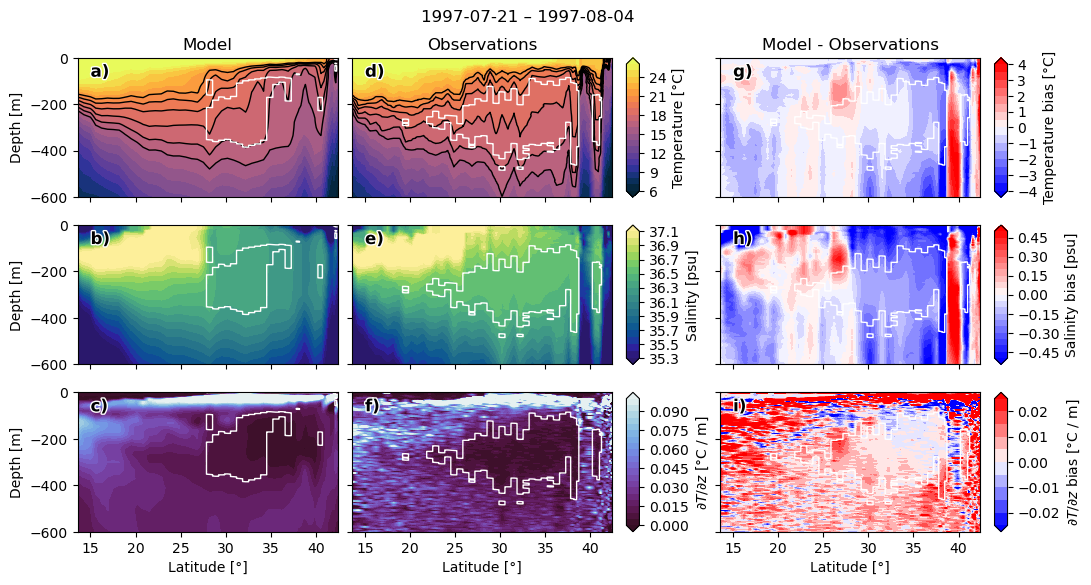

In [25]:
plot_comparison("A20_1997")

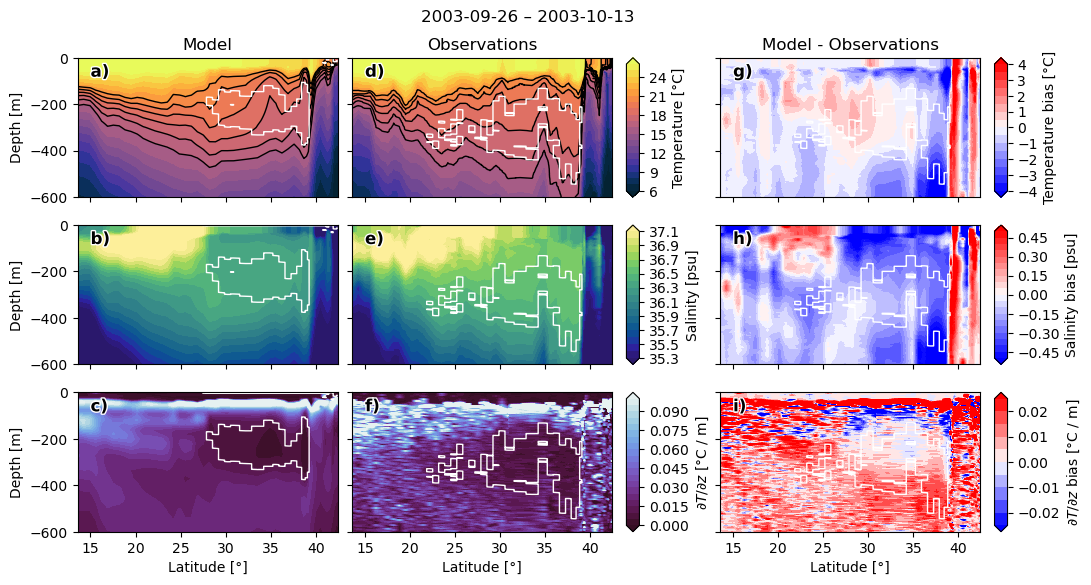

In [26]:
plot_comparison("A20_2003")

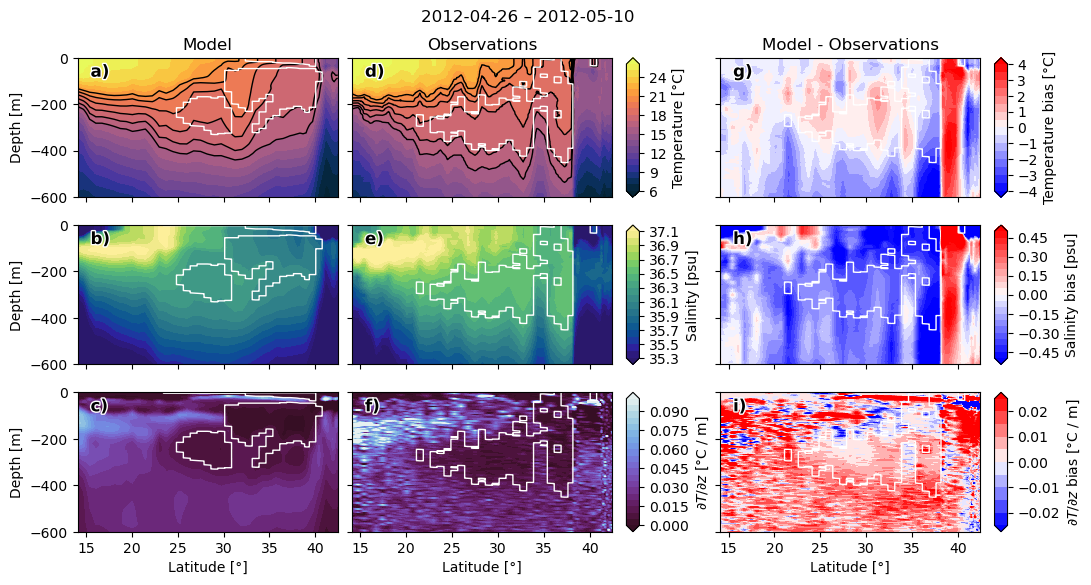

In [27]:
plot_comparison("A20_2012")

# Bottles

In [28]:
for cruise in ctd_data.keys():
    SA = gsw.SA_from_SP(SP = bottle_data[cruise]['ctd_salinity'], 
                        p = bottle_data[cruise]['pressure'],
                        lon = bottle_data[cruise]['longitude'],
                        lat = bottle_data[cruise]['latitude'])
    CT = gsw.CT_from_pt(SA, bottle_data[cruise]['ctd_temperature'])
    bottle_data[cruise]['rho_insitu'] = gsw.rho(SA, CT, bottle_data[cruise]['pressure'])

In [29]:
for cruise in freeglorys_data.keys():
    if cruise in ctd_data.keys():
        freeglorys_data[cruise]["DIC_interp"] = interp_to_section(freebiorys_dic_data[cruise], ctd_data[cruise], 'ctd_temperature')

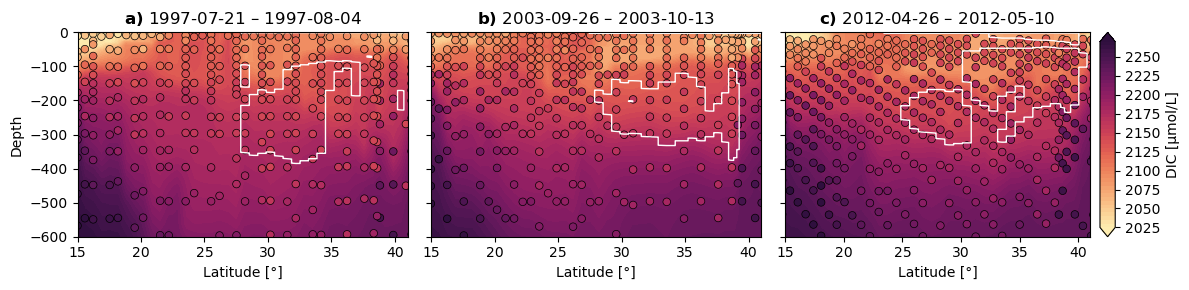

In [30]:
fig, axes = plt.subplots(ncols=3, figsize=(12,3))

cflevels = np.arange(2025, 2275, 5)
titles = {
    "A20_1997" : r"$\bf{a)}$ 1997-07-21 – 1997-08-04",
    "A20_2003" : r"$\bf{b)}$ 2003-09-26 – 2003-10-13",
    "A20_2012" : r"$\bf{c)}$ 2012-04-26 – 2012-05-10",
}
label = "DIC [µmol/L]"


for idx, cruise in enumerate(["A20_1997", "A20_2003", "A20_2012"]):
    
    ds_model_interp = freeglorys_data[cruise]["DIC_interp"] # to make gravimetric, uncomment #/ freeglorys_data[cruise]["rho_insitu_interp"] * 1000
    ds_bottle = bottle_data[cruise]

    z_flat = ds_model_interp.z.data.flatten()
    lat_flat = (ds_model_interp.z * 0 + ds_model_interp.latitude).data.flatten()
    data_flat = ds_model_interp.data.flatten()
    
    nanmask = np.isnan(data_flat) + np.isnan(lat_flat) + np.isnan(z_flat)
    
    contourf = axes[idx].tricontourf(lat_flat[~nanmask], z_flat[~nanmask], data_flat[~nanmask], levels=cflevels, cmap=cmocean.cm.matter, extend='both')
    
    qc_filter = (ds_bottle.total_carbon_qc == 2) * (ds_bottle.ctd_salinity_qc == 2)
    z_filter = ds_bottle.z > -600
    bottle_dic = ds_bottle.total_carbon.where(qc_filter * z_filter).values.astype(float).flatten()
    bottle_lat = ds_bottle.latitude.where(qc_filter * z_filter).values.astype(float).flatten()
    bottle_depth = ds_bottle.z.where(qc_filter * z_filter).values.astype(float).flatten()
    bottle_rho_insitu = ds_bottle.rho_insitu.where(qc_filter * z_filter).values.astype(float).flatten()
    bottle_dic_volumetric = bottle_dic * bottle_rho_insitu / 1000

    axes[idx].scatter(bottle_lat, bottle_depth, c=bottle_dic_volumetric, cmap=cmocean.cm.matter, vmin=cflevels[0], vmax=cflevels[-1], s=30, edgecolor='k', linewidth=0.5)
    axes[idx].set_title(f"{titles[cruise]}")

    axes[idx].tricontour(lat_flat[~nanmask], z_flat[~nanmask], freeglorys_data[cruise]["EDW_mask_glorys"].data.flatten()[~nanmask], levels=[0.5], colors='w', linewidths=1)

axes[0].set_ylabel("Depth")

for i, ax in enumerate(axes):
    ax.set_xlabel("Latitude [°]")
    ax.set_xlim(15, 41)
    ax.set_ylim(-600, 0)
    if i>0:
        ax.set_yticklabels([])

divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(contourf, cax=cax, orientation='vertical', label=f"{label}")

plt.tight_layout() 
plt.savefig("output/DIC_bottle_tracks.png", dpi=300, bbox_inches="tight")
plt.show()


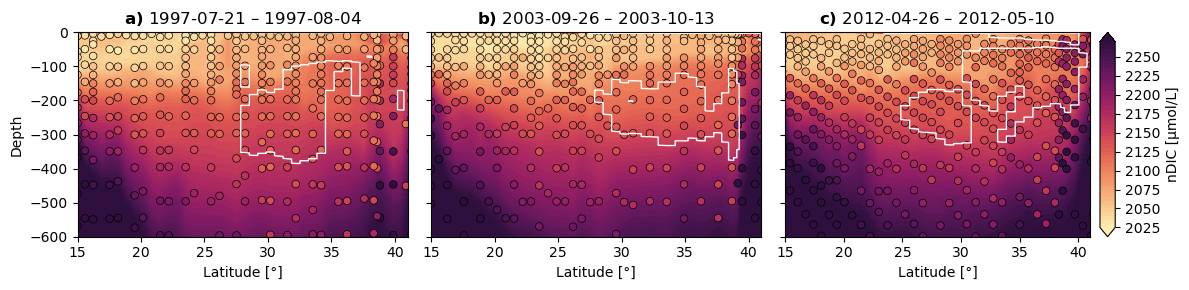

In [31]:
fig, axes = plt.subplots(ncols=3, figsize=(12,3))

cflevels = np.arange(2025, 2275, 5)
titles = {
    "A20_1997" : r"$\bf{a)}$ 1997-07-21 – 1997-08-04",
    "A20_2003" : r"$\bf{b)}$ 2003-09-26 – 2003-10-13",
    "A20_2012" : r"$\bf{c)}$ 2012-04-26 – 2012-05-10",
}
label = "nDIC [µmol/L]"


for idx, cruise in enumerate(["A20_1997", "A20_2003", "A20_2012"]):
    
    ndic_model_interp = (freeglorys_data[cruise]["DIC_interp"] / freeglorys_data[cruise]["S_interp"] * 36) # to make gravimetric, uncomment #/ freeglorys_data[cruise]["rho_insitu_interp"] * 1000
    ds_bottle = bottle_data[cruise]

    z_flat = ndic_model_interp.z.data.flatten()
    lat_flat = (ndic_model_interp.z * 0 + ndic_model_interp.latitude).data.flatten()
    ndic_flat = ndic_model_interp.data.flatten()
    
    nanmask = np.isnan(ndic_flat) + np.isnan(lat_flat) + np.isnan(z_flat)
    
    contourf = axes[idx].tricontourf(lat_flat[~nanmask], z_flat[~nanmask], ndic_flat[~nanmask], levels=cflevels, cmap=cmocean.cm.matter, extend='both')
    
    qc_filter = (ds_bottle.total_carbon_qc == 2) * (ds_bottle.ctd_salinity_qc == 2)
    z_filter = ds_bottle.z > -600
    bottle_ndic = (ds_bottle.total_carbon / ds_bottle.ctd_salinity * 36).where(qc_filter * z_filter).values.astype(float).flatten()
    bottle_lat = ds_bottle.latitude.where(qc_filter * z_filter).values.astype(float).flatten()
    bottle_depth = ds_bottle.z.where(qc_filter * z_filter).values.astype(float).flatten()
    bottle_rho_insitu = ds_bottle.rho_insitu.where(qc_filter * z_filter).values.astype(float).flatten()
    bottle_ndic_volumetric = bottle_ndic * bottle_rho_insitu / 1000

    axes[idx].scatter(bottle_lat, bottle_depth, c=bottle_ndic_volumetric, cmap=cmocean.cm.matter, vmin=cflevels[0], vmax=cflevels[-1], s=30, edgecolor='k', linewidth=0.5)
    axes[idx].set_title(f"{titles[cruise]}")

    axes[idx].tricontour(lat_flat[~nanmask], z_flat[~nanmask], freeglorys_data[cruise]["EDW_mask_glorys"].data.flatten()[~nanmask], levels=[0.5], colors='w', linewidths=1)

axes[0].set_ylabel("Depth")

for i, ax in enumerate(axes):
    ax.set_xlabel("Latitude [°]")
    ax.set_xlim(15, 41)
    ax.set_ylim(-600, 0)
    if i>0:
        ax.set_yticklabels([])

divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(contourf, cax=cax, orientation='vertical', label=f"{label}")

plt.tight_layout() 
plt.savefig("output/nDIC_bottle_tracks.png", dpi=300, bbox_inches="tight")
plt.show()


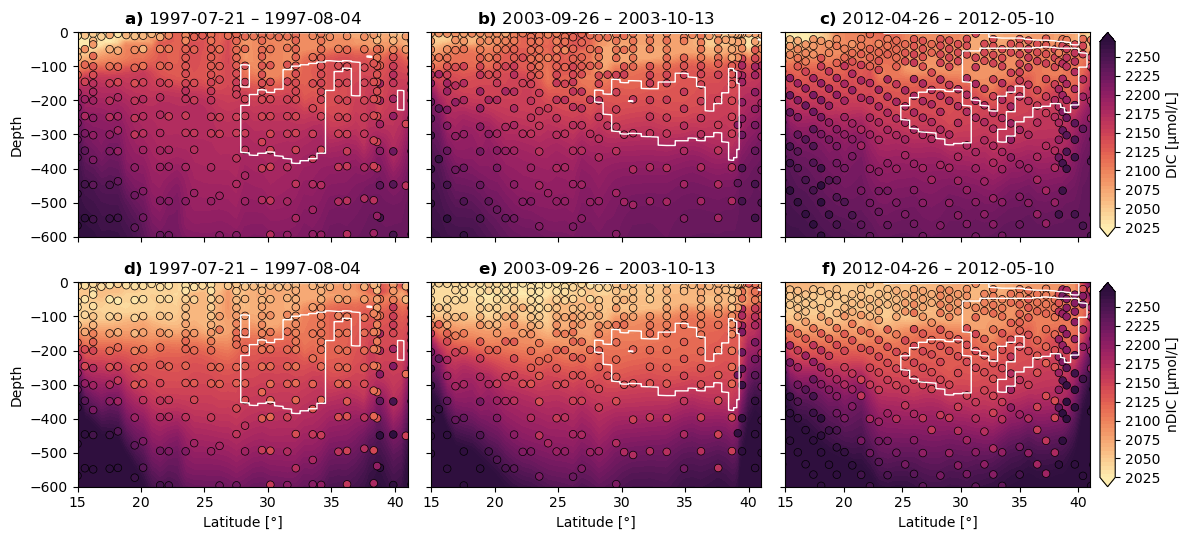

In [33]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12,5.5))

cflevels = np.arange(2025, 2275, 5)
titles = {
    "A20_1997" : "1997-07-21 – 1997-08-04",
    "A20_2003" : "2003-09-26 – 2003-10-13",
    "A20_2012" : "2012-04-26 – 2012-05-10",
}

for idx, cruise in enumerate(["A20_1997", "A20_2003", "A20_2012"]):
    
    ds_model_interp = freeglorys_data[cruise]["DIC_interp"] # to make gravimetric, uncomment #/ freeglorys_data[cruise]["rho_insitu_interp"] * 1000
    ndic_model_interp = (freeglorys_data[cruise]["DIC_interp"] / freeglorys_data[cruise]["S_interp"] * 36) # to make gravimetric, uncomment #/ freeglorys_data[cruise]["rho_insitu_interp"] * 1000

    ds_bottle = bottle_data[cruise]

    z_flat = ds_model_interp.z.data.flatten()
    lat_flat = (ds_model_interp.z * 0 + ds_model_interp.latitude).data.flatten()
    data_flat = ds_model_interp.data.flatten()
    ndic_flat = ndic_model_interp.data.flatten()

    
    nanmask = np.isnan(data_flat) + np.isnan(lat_flat) + np.isnan(z_flat)
    
    contourf1 = axes[0, idx].tricontourf(lat_flat[~nanmask], z_flat[~nanmask], data_flat[~nanmask], levels=cflevels, cmap=cmocean.cm.matter, extend='both')
    contourf2 = axes[1, idx].tricontourf(lat_flat[~nanmask], z_flat[~nanmask], ndic_flat[~nanmask], levels=cflevels, cmap=cmocean.cm.matter, extend='both')

    qc_filter = (ds_bottle.total_carbon_qc == 2) * (ds_bottle.ctd_salinity_qc == 2)
    z_filter = ds_bottle.z > -600
    bottle_dic = ds_bottle.total_carbon.where(qc_filter * z_filter).values.astype(float).flatten()
    bottle_ndic = (ds_bottle.total_carbon / ds_bottle.ctd_salinity * 36).where(qc_filter * z_filter).values.astype(float).flatten()

    bottle_lat = ds_bottle.latitude.where(qc_filter * z_filter).values.astype(float).flatten()
    bottle_depth = ds_bottle.z.where(qc_filter * z_filter).values.astype(float).flatten()
    bottle_rho_insitu = ds_bottle.rho_insitu.where(qc_filter * z_filter).values.astype(float).flatten()
    bottle_dic_volumetric = bottle_dic * bottle_rho_insitu / 1000
    bottle_ndic_volumetric = bottle_ndic * bottle_rho_insitu / 1000


    axes[0, idx].scatter(bottle_lat, bottle_depth, c=bottle_dic_volumetric, cmap=cmocean.cm.matter, vmin=cflevels[0], vmax=cflevels[-1], s=30, edgecolor='k', linewidth=0.5)
    axes[1, idx].scatter(bottle_lat, bottle_depth, c=bottle_ndic_volumetric, cmap=cmocean.cm.matter, vmin=cflevels[0], vmax=cflevels[-1], s=30, edgecolor='k', linewidth=0.5)

    axes[0, idx].set_title(r"$\bf{" + chr(97 + idx) + r")}$ " + f"{titles[cruise]}")
    axes[1, idx].set_title(r"$\bf{" + chr(97 + idx + 3) + r")}$ " + f"{titles[cruise]}")

    axes[0, idx].tricontour(lat_flat[~nanmask], z_flat[~nanmask], freeglorys_data[cruise]["EDW_mask_glorys"].data.flatten()[~nanmask], levels=[0.5], colors='w', linewidths=1)
    axes[1, idx].tricontour(lat_flat[~nanmask], z_flat[~nanmask], freeglorys_data[cruise]["EDW_mask_glorys"].data.flatten()[~nanmask], levels=[0.5], colors='w', linewidths=1)


for i, ax in enumerate(axes.flatten()):
    if i > 2:
        ax.set_xlabel("Latitude [°]")
    else:
        ax.set_xticklabels([])
    ax.set_xlim(15, 41)
    ax.set_ylim(-600, 0)
    if i % 3 != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Depth")

divider1 = make_axes_locatable(axes[0, 2])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)
fig.colorbar(contourf, cax=cax1, orientation='vertical', label=f"DIC [µmol/L]")

divider2 = make_axes_locatable(axes[1, 2])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)
fig.colorbar(contourf, cax=cax2, orientation='vertical', label=f"nDIC [µmol/L]")

plt.tight_layout() 
plt.savefig("output/DIC_nDIC_bottle_tracks.png", dpi=300, bbox_inches="tight")
plt.show()


In [35]:
def select_lon_lat_idx(ds, lon, lat):
    x = np.searchsorted(ds.nav_lon.isel(y=0), lon)
    y = np.searchsorted(ds.nav_lat.isel(x=x), lat)
    return x, y

In [36]:
ds_coords = xr.open_dataset(data_dir_freeglorys + "freeglorys2v4-NorthAtlanticGoM-daily_T_2000-01-01.nc")

In [37]:
def analyze_bottle_model(bottle_ds):
    df = pd.DataFrame(columns = ["bottle_dic", "bottle_lon", "bottle_lat", "bottle_pressure", "bottle_rho_insitu", "bottle_salinity", "bottle_depth", "bottle_date", "model_dic_volumetric", "model_T", "model_S"])

    for profile in tqdm.tqdm(bottle_ds.N_PROF, leave=True, desc="Profiles"):
        time = str(bottle_ds.sel(N_PROF=profile).time.values)[:10]
        
        lon = float(bottle_ds.sel(N_PROF=profile).longitude)
        lat = float(bottle_ds.sel(N_PROF=profile).latitude)

        xidx, yidx = select_lon_lat_idx(ds_coords, lon, lat)

        ds_T = xr.open_dataset(data_dir_freeglorys + f"freeglorys2v4-NorthAtlanticGoM-daily_T_{time}.nc").isel(x=xidx, y=yidx).votemper
        ds_S = xr.open_dataset(data_dir_freeglorys + f"freeglorys2v4-NorthAtlanticGoM-daily_S_{time}.nc").isel(x=xidx, y=yidx).vosaline
        ds_DIC = xr.open_dataset(data_dir_freebiorys + f"freebiorys2v4-NorthAtlanticGoM-daily_dic_{time}.nc").isel(x=xidx, y=yidx).dic
        
        for level in tqdm.tqdm(bottle_ds.N_LEVELS, leave=False, desc="Levels"):

            sub_ds = bottle_ds.sel(N_PROF=profile, N_LEVELS=level)

            if not np.isnan(sub_ds.total_carbon):
                
                depth = float(gsw.z_from_p(sub_ds.pressure, sub_ds.latitude))
                if depth < -600:
                    break

                append_row = pd.Series({"bottle_dic": float(sub_ds.total_carbon),
                                        "bottle_lon": lon,
                                        "bottle_lat": lat,
                                        "bottle_pressure": float(sub_ds.pressure),
                                        "bottle_rho_insitu": float(sub_ds.rho_insitu),
                                        "bottle_salinity": float(sub_ds.ctd_salinity),
                                        "bottle_depth": depth,
                                        "bottle_date": time,
                                        "model_dic_volumetric": float(ds_DIC.interp(deptht=-depth).values),
                                        # "model_dic_volumetric": float(ds_DIC.dic.sel(deptht=-depth, method='nearest').values),
                                        "model_T": float(ds_T.interp(deptht=-depth).values),
                                        "model_S": float(ds_S.interp(deptht=-depth).values),
                                        # "model_rho_insitu": float(model_rho_insitu.interp(deptht=-depth).values)
                                        })
                df.loc[len(df.index)] = append_row

    return df

In [38]:
dic_comparison_df = {}
for cruise in ["A20_1997", "A20_2003", "A20_2012"]:
    dic_comparison_df[cruise] = analyze_bottle_model(bottle_data[cruise])

    dic_comparison_df[cruise]["CT"] = gsw.CT_from_pt(dic_comparison_df[cruise].model_S.values, dic_comparison_df[cruise].model_T.values)
    dic_comparison_df[cruise]["model_insitu_density"] = gsw.rho_t_exact(dic_comparison_df[cruise].model_S.values, dic_comparison_df[cruise].CT.values, dic_comparison_df[cruise].bottle_pressure.values)
    dic_comparison_df[cruise]["model_dic_gravimetric"] = dic_comparison_df[cruise].model_dic_volumetric / dic_comparison_df[cruise].model_insitu_density * 1000
    dic_comparison_df[cruise]["bottle_dic_volumetric"] = dic_comparison_df[cruise].bottle_dic * dic_comparison_df[cruise].bottle_rho_insitu / 1000


Profiles:   0%|          | 0/53 [00:00<?, ?it/s]

Profiles: 100%|██████████| 47/47 [01:05<00:00,  1.38s/it]


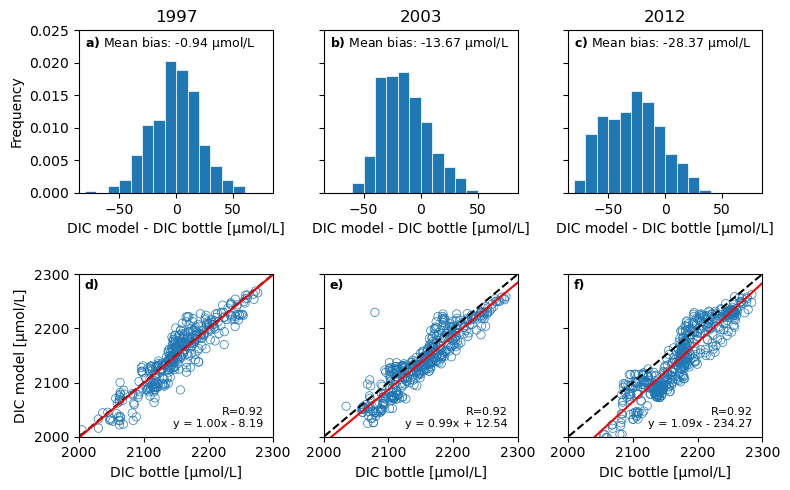

In [39]:
titles = {
    "A20_1997" : "1997",
    "A20_2003" : "2003",
    "A20_2012" : "2012",
}

labels = [["a)", "b)", "c)"], ["d)", "e)", "f)"]]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(8, 5))
for colidx, cruise in enumerate(["A20_1997", "A20_2003", "A20_2012"]):    
    mask = np.isfinite(dic_comparison_df[cruise].model_dic_volumetric.values.astype(float))
    bottle_dic = dic_comparison_df[cruise].bottle_dic_volumetric.values.astype(float)[mask]
    model_dic = dic_comparison_df[cruise].model_dic_volumetric.values.astype(float)[mask]

    corr_stats = stats.pearsonr(bottle_dic, model_dic)
    slope, intercept, r_value, p_value, std_err = stats.linregress(bottle_dic, model_dic)
    mean_bias = np.mean(model_dic - bottle_dic)

    ax[0, colidx].hist((dic_comparison_df[cruise].model_dic_volumetric - dic_comparison_df[cruise].bottle_dic_volumetric).astype(float), bins=np.arange(-80, 80, 10), density=True, edgecolor='white', linewidth=0.5)
    ax[0, colidx].set_xlabel("DIC model - DIC bottle [µmol/L]")
    ax[0, colidx].set_xlim([-85, 85])
    ax[0, colidx].set_title(titles[cruise])
    ax[0, colidx].set_ylim(0, 0.025)
    ax[0, colidx].text(0.03, 0.97, r"$\bf{" + f"{labels[0][colidx]}"+ r"}$ " + f"Mean bias: {mean_bias:.2f} µmol/L", transform=ax[0, colidx].transAxes, ha='left', va='top', fontsize=9)

    ax[1, colidx].scatter(dic_comparison_df[cruise].bottle_dic_volumetric, dic_comparison_df[cruise].model_dic_volumetric, color='none', edgecolor='C0', linewidth=0.5)
    ax[1, colidx].plot([1975, 2300], [1975, 2300], color="black", linestyle="--", label="1:1")
    ax[1, colidx].set_xlim([2000, 2300])
    ax[1, colidx].set_ylim([2000, 2300])
    ax[1, colidx].set_xlabel("DIC bottle [µmol/L]")
    ax[1, colidx].plot([1975, 2300], [1975*slope + intercept, 2300*slope + intercept], color='red')
    ax[1, colidx].text(0.03, 0.97, f"{labels[1][colidx]}", transform=ax[1, colidx].transAxes, ha='left', va='top', fontsize=9, fontweight='bold')
    ax[1, colidx].text(0.95, 0.05, f"R={r_value:.2f}\ny = {slope:.2f}x {'+' if np.sign(intercept)== 1 else '-'} {np.abs(intercept):.2f}", transform=ax[1, colidx].transAxes, ha='right', va='bottom', fontsize=8)
    
    if colidx > 0:
        ax[0, colidx].set_yticklabels([])
        ax[1, colidx].set_yticklabels([])

    
ax[0, 0].set_ylabel("Frequency")
ax[1, 0].set_ylabel("DIC model [µmol/L]")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)
plt.savefig("output/DIC_bottle_vs_model.pdf", bbox_inches="tight")
plt.show()


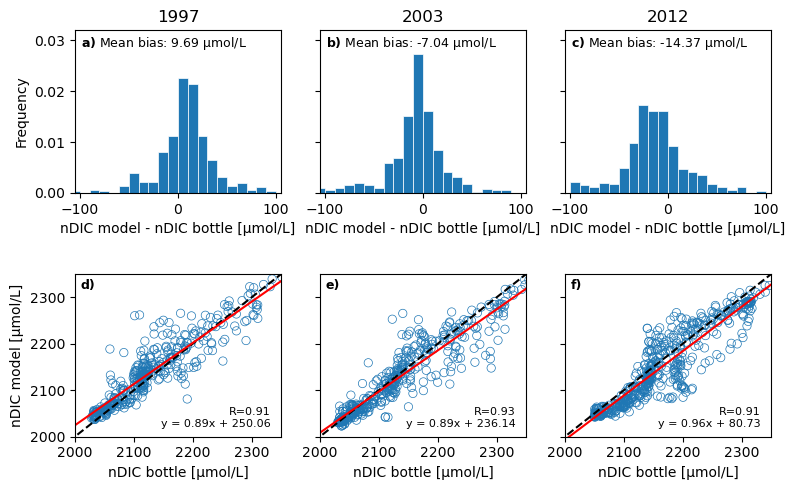

In [40]:
for cruise in ["A20_1997", "A20_2003", "A20_2012"]:
    dic_comparison_df[cruise]["model_insitu_density"] = gsw.rho_t_exact(dic_comparison_df[cruise].model_S.values, dic_comparison_df[cruise].CT.values, dic_comparison_df[cruise].bottle_pressure.values)
    dic_comparison_df[cruise]["model_ndic_volumetric"] = (dic_comparison_df[cruise].model_dic_volumetric / dic_comparison_df[cruise].model_S.values * 36) 
    dic_comparison_df[cruise]["model_ndic_gravimetric"] = dic_comparison_df[cruise].model_ndic_volumetric / dic_comparison_df[cruise].model_insitu_density * 1000
    dic_comparison_df[cruise]["bottle_ndic"] = (dic_comparison_df[cruise].bottle_dic / dic_comparison_df[cruise].bottle_salinity * 36)
    dic_comparison_df[cruise]["bottle_ndic_volumetric"] = dic_comparison_df[cruise]["bottle_ndic"] * dic_comparison_df[cruise].bottle_rho_insitu / 1000

titles = {
    "A20_1997" : "1997",
    "A20_2003" : "2003",
    "A20_2012" : "2012",
}

labels = [["a)", "b)", "c)"], ["d)", "e)", "f)"]]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(8, 5))
for colidx, cruise in enumerate(["A20_1997", "A20_2003", "A20_2012"]):    
    mask = np.isfinite(dic_comparison_df[cruise].model_ndic_volumetric.values.astype(float))
    bottle_ndic = dic_comparison_df[cruise].bottle_ndic_volumetric.values.astype(float)[mask]
    model_ndic = dic_comparison_df[cruise].model_ndic_volumetric.values.astype(float)[mask]

    corr_stats = stats.pearsonr(bottle_ndic, model_ndic)
    slope, intercept, r_value, p_value, std_err = stats.linregress(bottle_ndic, model_ndic)
    mean_bias = np.mean(model_ndic - bottle_ndic)
    ax[0, colidx].hist((model_ndic- bottle_ndic).astype(float), bins=np.arange(np.floor((bottle_ndic - model_ndic).min()/10)*10, np.ceil((bottle_ndic - model_ndic).max()/10)*10, 10), density=True, edgecolor='white', linewidth=0.5)

    ax[0, colidx].set_xlabel("nDIC model - nDIC bottle [µmol/L]")
    ax[0, colidx].set_xlim([-105, 105])
    ax[0, colidx].set_title(titles[cruise])
    ax[0, colidx].set_ylim(0, 0.032)
    ax[0, colidx].text(0.03, 0.97, r"$\bf{" + f"{labels[0][colidx]}"+ r"}$ " + f"Mean bias: {mean_bias:.2f} µmol/L", transform=ax[0, colidx].transAxes, ha='left', va='top', fontsize=9)

    ax[1, colidx].scatter(dic_comparison_df[cruise].bottle_ndic_volumetric, dic_comparison_df[cruise].model_ndic_volumetric, color='none', edgecolor='C0', linewidth=0.5)
    ax[1, colidx].plot([1975, 2350], [1975, 2350], color="black", linestyle="--", label="1:1")
    ax[1, colidx].set_xlim([2000, 2350])
    ax[1, colidx].set_ylim([2000, 2350])
    ax[1, colidx].set_xlabel("nDIC bottle [µmol/L]")
    ax[1, colidx].plot([1975, 2350], [1975*slope + intercept, 2350*slope + intercept], color='red')
    ax[1, colidx].text(0.03, 0.97, f"{labels[1][colidx]}", transform=ax[1, colidx].transAxes, ha='left', va='top', fontsize=9, fontweight='bold')
    ax[1, colidx].text(0.95, 0.05, f"R={r_value:.2f}\ny = {slope:.2f}x {'+' if np.sign(intercept)== 1 else '-'} {np.abs(intercept):.2f}", transform=ax[1, colidx].transAxes, ha='right', va='bottom', fontsize=8)
    
    if colidx > 0:
        ax[0, colidx].set_yticklabels([])
        ax[1, colidx].set_yticklabels([])

    
ax[0, 0].set_ylabel("Frequency")
ax[1, 0].set_ylabel("nDIC model [µmol/L]")

plt.tight_layout()
fig.subplots_adjust(hspace=0.5)
plt.savefig("output/nDIC_bottle_vs_model.pdf", bbox_inches="tight")
plt.show()
